In [1]:
import re
import pickle
import numpy as np
import pandas as pd
import string
import io

from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(7)

In [3]:
def mod_code(text):
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    return text

def mod_char(text):
    text = " ".join(word.replace('[^\w\s]',' ') for word in text.split())
    return text

def mod_punctuations(text):
    for punctuation in string.punctuation:
        text = " ".join(word.replace(punctuation, '') for word in text.split())
    return text

def mod_lower(text):
    text = text.lower()
    return text

stop = stopwords.words('english')
def mod_stop(text):
    text = ' '.join(word for word in text.split() if word not in stop)
    return text

def rem_num(text):
    text = ' '.join(word for word in text.split() if not word.isdigit())
    return text

def clean_df(df,col):
    df[col] = df[col].apply(rem_num)
    df[col] = df[col].apply(mod_char)
    df[col] = df[col].apply(mod_punctuations)
    df[col] = df[col].apply(mod_lower)
    df[col] = df[col].apply(mod_stop)
    df[col] = df[col].apply(mod_code)
    
def clean_txt(text):
    text = mod_char(text)
    text = mod_punctuations(text)
    text = mod_lower(text)
    text = mod_code(text)
    text = mod_stop(text)
    
    return text

In [4]:
# pre-trained word vectors - 840B tokens, 2.2M vocab, cased, 300d vectors,
# Function to create word embeddings

def gloveVec(filename):
    embeddings = {}
    f = io.open(filename, encoding='utf-8')
    i = 0
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings[word] = coefs
        except ValueError:
            i += 1
    f.close()
    return embeddings

In [5]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 20000

def createVocabAndData(sentences):
    
    # Create Tokenizer
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    # Apply on text
    tokenizer.fit_on_texts(sentences)
    
    # Convert texts to list of words
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Create word index (Dictionary of words and their assigned integer)
    vocab = tokenizer.word_index
    
    # used to ensure that all sequences in a list have the same length
    # 0 will be padded to the other sequences so their length matches
    # the longest sequences
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    return vocab,data,tokenizer

In [6]:
# Create embedding matrix
EMBEDDING_DIM = 300

def createEmbeddingMatrix(word_index,embeddings_index):
    nb_words = min(MAX_NB_WORDS, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i > MAX_NB_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [7]:
df = pd.read_pickle("df.pkl")
df.head()

,labels,texts
4,sadness,plucks withered leaf balsam looks grasscovered...
5,sadness,old maid thinking
7,joy,poor little children happy merrily play romp t...
8,sadness,red cheeks angels eyes shoes stockings
9,fear,dance green rampart place according old story ...


In [8]:
len(df)

13646

In [9]:
pd.value_counts(df['labels'])

joy            2162
shame-guilt    2121
fear           2084
neutral        2028
sadness        1913
anger          1809
disgust        1529
Name: labels, dtype: int64

In [10]:
scale_mapper = {'neutral':6,
                'anger':5, 
                'disgust':4,
                'fear':3,
                'joy':2,
                'sadness':1,
                'shame-guilt':0}

df['labels'].replace(scale_mapper, inplace=True)

labels = df['labels'].tolist()
text = df['texts'].tolist()

In [11]:
text_mod = []

for i in text:
    text_mod.append(i.encode('utf-8'))

In [12]:
print(len(labels))
print(len(text_mod))

13646
13646


In [13]:
sentences = text_mod

# Converts a class vector (integers) to binary class matrix.
# 7 classes are used becos there are 7 emotions
labels = to_categorical(labels, num_classes=7)

In [14]:
# Create word embeddings
embeddings = gloveVec('glove.840B.300d.txt')

In [15]:
vocab, data, tokenizer = createVocabAndData(sentences)

In [16]:
embedding_mat = createEmbeddingMatrix(vocab,embeddings)

In [17]:
print("Train Test split")
TEST_SPLIT = 0.15
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=TEST_SPLIT, random_state=42)

Train Test split


In [20]:
MAX_SEQUENCE_LENGTH = 100

model = Sequential()
n, embedding_dims = embedding_mat.shape

model.add(Embedding(n, embedding_dims, weights=[embedding_mat], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(128, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# checkpoint
filepath='weights.best.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          4031700   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
_________________________________________________________________
activation_2 (Activation)    (None, 7)                 0         
Total params: 4,252,251
Trainable params: 220,551
Non-trainable params: 4,031,700
_________________________________________________________________
None


In [21]:
VALIDATION_SPLIT = 0.15

history = model.fit(X_train, y_train, validation_split=VALIDATION_SPLIT, epochs=50, batch_size=128,callbacks=callbacks_list)
model.save('lstm_model.h5')

Train on 9859 samples, validate on 1740 samples
Epoch 1/50
9859/9859 [==============================] - 95s - loss: 1.7825 - acc: 0.2947 - val_loss: 1.5343 - val_acc: 0.4224
Epoch 2/50
9859/9859 [==============================] - 98s - loss: 1.6121 - acc: 0.3807 - val_loss: 1.4375 - val_acc: 0.4667
Epoch 3/50
9859/9859 [==============================] - 86s - loss: 1.5442 - acc: 0.4084 - val_loss: 1.3897 - val_acc: 0.4776
Epoch 4/50
9859/9859 [==============================] - 98s - loss: 1.5080 - acc: 0.4280 - val_loss: 1.3597 - val_acc: 0.4920
Epoch 5/50
9859/9859 [==============================] - 96s - loss: 1.4740 - acc: 0.4424 - val_loss: 1.3299 - val_acc: 0.5086
Epoch 6/50
9859/9859 [==============================] - 87s - loss: 1.4379 - acc: 0.4620 - val_loss: 1.3089 - val_acc: 0.5063
Epoch 7/50
9859/9859 [==============================] - 98s - loss: 1.4065 - acc: 0.4714 - val_loss: 1.2963 - val_acc: 0.5126
Epoch 8/50
9859/9859 [==============================] - 99s - loss: 1.

['acc', 'loss', 'val_acc', 'val_loss']


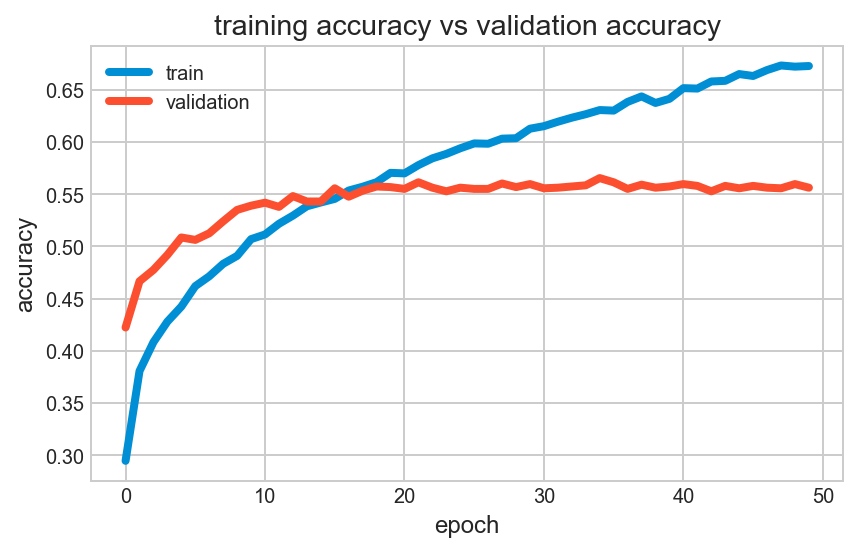

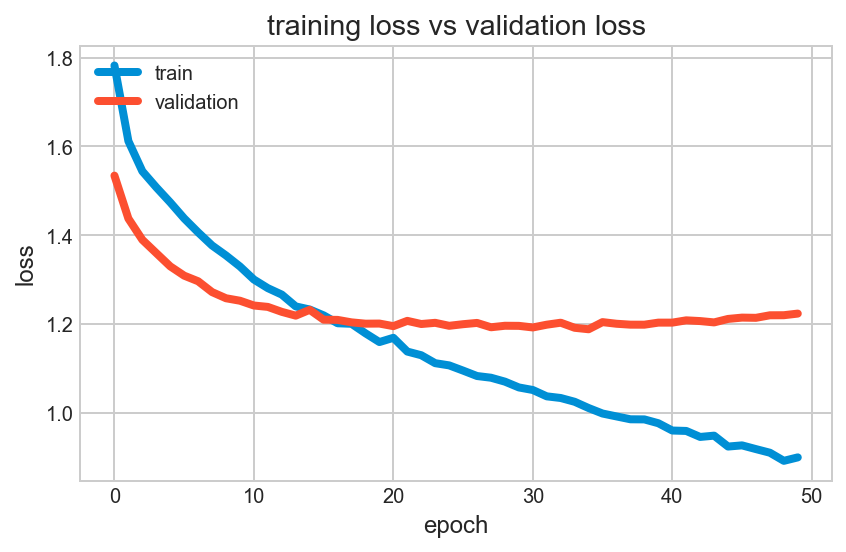

In [22]:
import matplotlib.pyplot as plt

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('training accuracy vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [18]:
from keras.models import load_model
model = load_model('lstm_model.h5') 

MAX_SEQUENCE_LENGTH = 100

model = Sequential()
n, embedding_dims = embedding_mat.shape

model.add(Embedding(n, embedding_dims, weights=[embedding_mat], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(128, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(7))
model.add(Activation('softmax'))

model.load_weights('weights.best.h5')

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

Created model and loaded weights from file


In [19]:
preds = model.predict(X_test,verbose = 2)

preds_mod = []
for i in preds:
    arr = []
    for j,k in enumerate(i):
        if j == np.argmax(i):
            arr.append(1)
        else:
            arr.append(0)
    preds_mod.append(arr)
    
preds_mod = np.asarray(preds_mod)
len(preds_mod)

2047

In [20]:
y_preds = []
for emotions in preds_mod:

    if(np.argmax(emotions) == 0):
        feelings = "shame-guilt"
    elif (np.argmax(emotions) == 1):
        feelings = "sadness"
    elif (np.argmax(emotions) == 2):
        feelings = "joy"
    elif (np.argmax(emotions) == 3):
        feelings = "fear"
    elif (np.argmax(emotions) == 4):
        feelings = "disgust"
    elif (np.argmax(emotions) == 5):
        feelings = "anger"
    elif (np.argmax(emotions) == 6):
        feelings = "neutral"
    y_preds.append(feelings)
len(y_preds)

2047

In [21]:
Y_test = []
for emotions in y_test:

    if(np.argmax(emotions) == 0):
        feelings = "shame-guilt"
    elif (np.argmax(emotions) == 1):
        feelings = "sadness"
    elif (np.argmax(emotions) == 2):
        feelings = "joy"
    elif (np.argmax(emotions) == 3):
        feelings = "fear"
    elif (np.argmax(emotions) == 4):
        feelings = "disgust"
    elif (np.argmax(emotions) == 5):
        feelings = "anger"
    elif (np.argmax(emotions) == 6):
        feelings = "neutral"
    Y_test.append(feelings)
len(Y_test)

2047

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(Y_test, y_preds))

             precision    recall  f1-score   support

      anger       0.52      0.49      0.50       271
    disgust       0.56      0.50      0.53       230
       fear       0.58      0.48      0.52       308
        joy       0.58      0.65      0.61       305
    neutral       0.47      0.53      0.50       316
    sadness       0.67      0.61      0.64       290
shame-guilt       0.61      0.69      0.65       327

avg / total       0.57      0.57      0.57      2047



In [23]:
cm = confusion_matrix(Y_test, y_preds)
print(cm)

[[132  23  22  12  23  15  44]
 [ 35 115   7  14  19  13  27]
 [ 13  16 148  25  66  18  22]
 [  9   6  16 199  42  17  16]
 [ 19  16  36  55 169   8  13]
 [ 10   9  21  23  28 177  22]
 [ 34  19   7  16   9  17 225]]


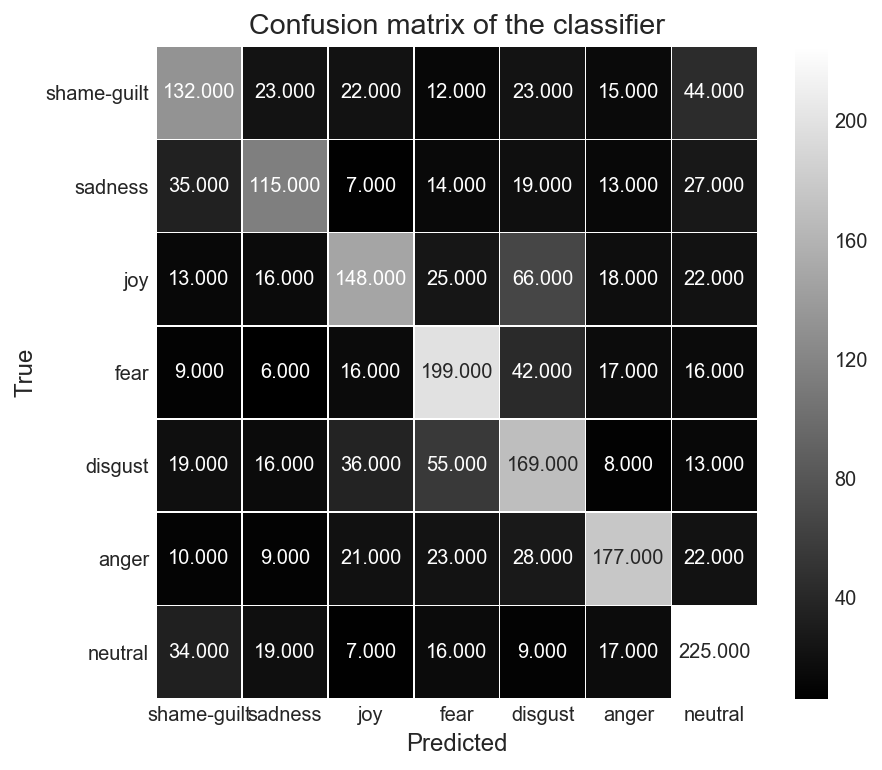

In [24]:
fig = plt.figure(figsize=(6,6))
labels = ['shame-guilt','sadness','joy','fear','disgust','anger','neutral']
ax= sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.3, square = False, cmap = plt.cm.gray);
plt.title('Confusion matrix of the classifier')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.yticks(rotation=0)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
y_preds = []
for emotions in preds_mod:

    if(np.argmax(emotions) == 0):
        feelings = "shame-guilt"
    elif (np.argmax(emotions) == 1):
        feelings = "sadness"
    elif (np.argmax(emotions) == 2):
        feelings = "joy"
    elif (np.argmax(emotions) == 3):
        feelings = "fear"
    elif (np.argmax(emotions) == 4):
        feelings = "disgust"
    elif (np.argmax(emotions) == 5):
        feelings = "anger"
    elif (np.argmax(emotions) == 6):
        feelings = "neutral"
    y_preds.append(feelings)
len(y_preds)

2047

In [26]:
scores= model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

acc: 56.91%


In [27]:
def predict_emo(msg):
    text = [clean_txt(str(msg[0]))]
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', value=0)
    emotions = model.predict(text,verbose = 2)[0]
    
    if(np.argmax(emotions) == 0):
        feelings = "shame-guilt"
    elif (np.argmax(emotions) == 1):
        feelings = "sadness"
    elif (np.argmax(emotions) == 2):
        feelings = "joy"
    elif (np.argmax(emotions) == 3):
        feelings = "fear"
    elif (np.argmax(emotions) == 4):
        feelings = "disgust"
    elif (np.argmax(emotions) == 5):
        feelings = "anger"
    elif (np.argmax(emotions) == 6):
        feelings = "neutral"
        
    print('Dorminant Emotion: '+ feelings )
    print("shame-guilt: %.2f%%" % (emotions[0]*100 ))
    print("sadness: %.2f%%" % (emotions[1]*100 ))
    print("joy: %.2f%%" % (emotions[2]*100 ))
    print("fear: %.2f%%" % (emotions[3]*100 ))
    print("disgust: %.2f%%" % (emotions[4]*100 ))
    print("anger: %.2f%%" % (emotions[5]*100 ))
    print("neutral: %.2f%%" % (emotions[6]*100 ))

In [28]:
msg = ["very good"]
predict_emo(msg)

Dorminant Emotion: joy
shame-guilt: 2.45%
sadness: 5.80%
joy: 48.64%
fear: 9.85%
disgust: 5.01%
anger: 7.67%
neutral: 20.59%


In [148]:
import csv
alice = pd.read_csv('Alice.txt',sep ='\t',names = ['line'],quoting=csv.QUOTE_NONE, encoding='utf-8')

In [149]:
len(alice)

1245

In [150]:
def mod_code(text):
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    return text

def mod_char(text):
    text = " ".join(word.replace('[^\w\s]',' ') for word in text.split())
    return text

def mod_punctuations(text):
    for punctuation in string.punctuation:
        text = " ".join(word.replace(punctuation, '') for word in text.split())
    return text

def mod_lower(text):
    text = text.lower()
    return text

stop = stopwords.words('english')
def mod_stop(text):
    text = ' '.join(word for word in text.split() if word not in stop)
    return text

def rem_num(text):
    text = ' '.join(word for word in text.split() if not word.isdigit())
    return text

def clean_df(df,col):
    df[col] = df[col].apply(rem_num)
    df[col] = df[col].apply(mod_char)
    df[col] = df[col].apply(mod_punctuations)
    df[col] = df[col].apply(mod_lower)
    df[col] = df[col].apply(mod_stop)
    df[col] = df[col].apply(mod_code)
    
def clean_txt(text):
    text = mod_char(text)
    text = mod_punctuations(text)
    text = mod_lower(text)
    text = mod_code(text)
    text = mod_stop(text)
    
    return text

In [151]:
clean_df(alice,'line')
alice.head()

,line
0,alice beginning get tired sitting sister
1,bank nothing twice
2,peeped book sister reading
3,pictures conversations use book
4,thought alice without pictures conversations


In [152]:
def emo_arc(text,num):
    text = [clean_txt(str(text))]
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', value=0)
    emotions = model.predict(text,verbose = 2)[0][num]
    
    return emotions

In [153]:
alice['shame-guilt'] = alice['line'].apply(lambda x:emo_arc(x,0))
alice['sadness'] = alice['line'].apply(lambda x:emo_arc(x,1))
alice['joy'] = alice['line'].apply(lambda x:emo_arc(x,2))
alice['fear'] = alice['line'].apply(lambda x:emo_arc(x,3))
alice['disgust'] = alice['line'].apply(lambda x:emo_arc(x,4))
alice['anger'] = alice['line'].apply(lambda x:emo_arc(x,5))
alice['neutral'] = alice['line'].apply(lambda x:emo_arc(x,6))

In [154]:
alice.shape

(1245, 8)

In [36]:
f = lambda x,y: [ x[i:i+y] for i in range(0,len(x),y)]
l = f(range(0, 896), 25)
len(l)

36

In [39]:
shame = []
for j in l:
    shame.append(alice['shame-guilt'].iloc[j[0]:j[-1]+1].mean())
sadness = []
for j in l:
    sadness.append(alice['sadness'].iloc[j[0]:j[-1]+1].mean())
joy = []
for j in l:
    joy.append(alice['joy'].iloc[j[0]:j[-1]+1].mean())
fear = []
for j in l:
    fear.append(alice['fear'].iloc[j[0]:j[-1]+1].mean())
disgust = []
for j in l:
    disgust.append(alice['disgust'].iloc[j[0]:j[-1]+1].mean())
anger = []
for j in l:
    anger.append(alice['anger'].iloc[j[0]:j[-1]+1].mean())
neutral = []
for j in l:
    neutral.append(alice['neutral'].iloc[j[0]:j[-1]+1].mean())
    
x = []
for i in range(0,37):
    x.append(i)
    
alice_arc = pd.DataFrame(list(zip(x,shame,disgust,anger,neutral,sadness,joy,fear,)),
              columns=['x','shame-guilt','disgust','anger','neutral','sadness','joy','fear'])

In [155]:
shame_mean =alice_arc['shame-guilt'].mean()
sadness_mean = alice_arc['sadness'].mean()
joy_mean = alice_arc['joy'].mean()
fear_mean = alice_arc['fear'].mean()
disgust_mean = alice_arc['disgust'].mean()
anger_mean = alice_arc['anger'].mean()
neutral_mean = alice_arc['neutral'].mean()

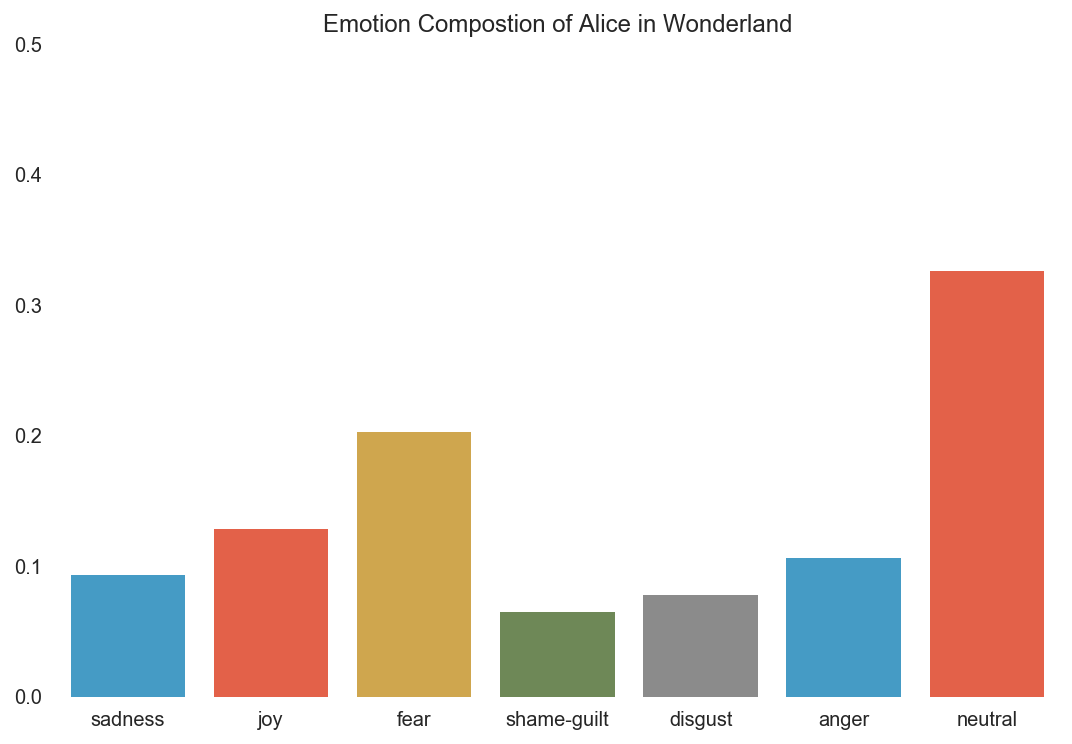

In [158]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
rs = np.random.RandomState(7)
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()

plt.title('Emotion Compostion of Alice in Wonderland')
plt.ylim((0,0.5))
plt.box(on=None)
g = sns.barplot(x = ['sadness','joy','fear','shame-guilt','disgust','anger','neutral'], 
                y = [sadness_mean,joy_mean,fear_mean,shame_mean,disgust_mean,anger_mean,neutral_mean],
                palette=sns.color_palette())

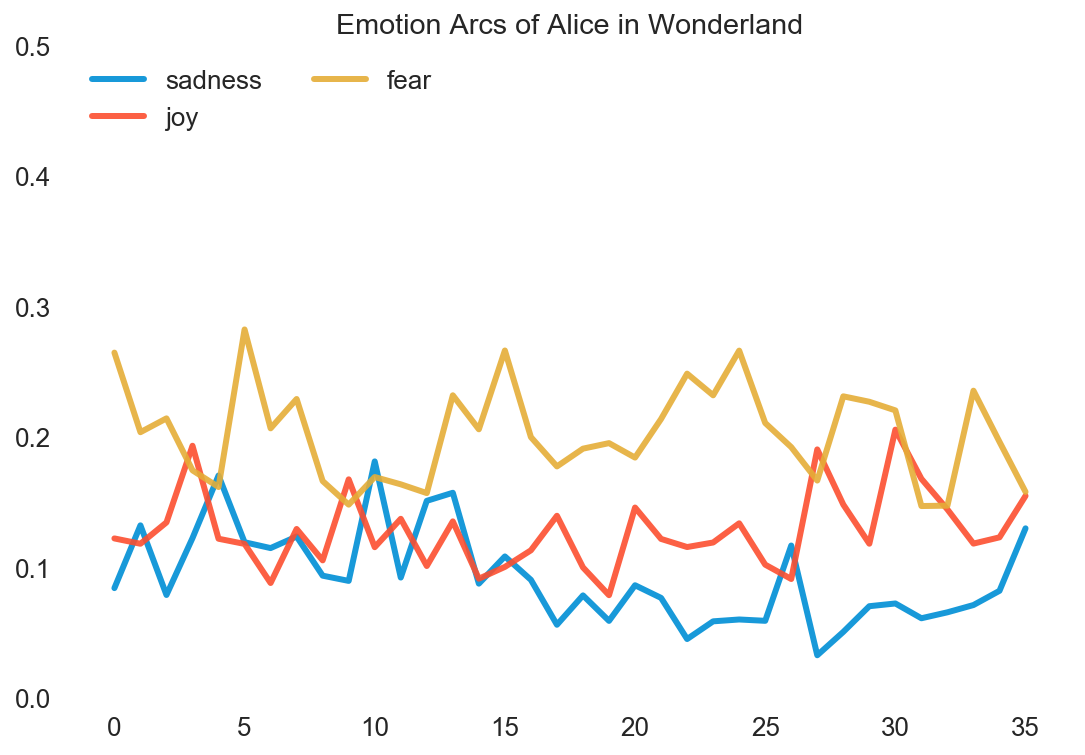

In [90]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
sns.set_style('white')
%matplotlib inline

fig = plt.figure(figsize=(8,6))

# multiple line plot
from matplotlib import lines
lines_array = list(lines.lineStyles.keys())

num=0
for column in alice_arc.drop(['x','shame-guilt','disgust','anger','neutral'], axis=1):
    num+=1
    plt.plot(alice_arc['x'], alice_arc[column], marker='', linewidth=3, alpha=0.9, 
             label=column)

plt.title('Emotion Arcs of Alice in Wonderland')
plt.ylim(0,0.5)
plt.box(on=None)
plt.legend(loc=2, ncol=2)

In [117]:
import csv
gray = pd.read_csv('Dorian_Gray.txt',sep ='\t',names = ['line'],quoting=csv.QUOTE_NONE, encoding='utf-8')

In [118]:
len(gray)

6925

In [120]:
clean_df(gray,'line')
gray.head()

,line
0,artist creator beautiful things reveal art
1,conceal artist arts aim critic translate
2,another manner new material impression beautiful
3,things
4,highest lowest form criticism mode autobiography


In [122]:
gray['shame-guilt'] = gray['line'].apply(lambda x:emo_arc(x,0))
gray['sadness'] = gray['line'].apply(lambda x:emo_arc(x,1))
gray['joy'] = gray['line'].apply(lambda x:emo_arc(x,2))
gray['fear'] = gray['line'].apply(lambda x:emo_arc(x,3))
gray['disgust'] = gray['line'].apply(lambda x:emo_arc(x,4))
gray['anger'] = gray['line'].apply(lambda x:emo_arc(x,5))
gray['neutral'] = gray['line'].apply(lambda x:emo_arc(x,6))

In [123]:
f = lambda x,y: [ x[i:i+y] for i in range(0,len(x),y)]
l = f(range(0, 896), 25)
len(l)

36

In [159]:
shame = []
for j in l:
    shame.append(gray['shame-guilt'].iloc[j[0]:j[-1]+1].mean())
sadness = []
for j in l:
    sadness.append(gray['sadness'].iloc[j[0]:j[-1]+1].mean())
joy = []
for j in l:
    joy.append(gray['joy'].iloc[j[0]:j[-1]+1].mean())
fear = []
for j in l:
    fear.append(gray['fear'].iloc[j[0]:j[-1]+1].mean())
disgust = []
for j in l:
    disgust.append(gray['disgust'].iloc[j[0]:j[-1]+1].mean())
anger = []
for j in l:
    anger.append(gray['anger'].iloc[j[0]:j[-1]+1].mean())
neutral = []
for j in l:
    neutral.append(gray['neutral'].iloc[j[0]:j[-1]+1].mean())
    
x = []
for i in range(0,37):
    x.append(i)
    
gray_arc = pd.DataFrame(list(zip(x,shame,disgust,anger,neutral,sadness,joy,fear,)),
              columns=['x','shame-guilt','disgust','anger','neutral','sadness','joy','fear'])

In [160]:
shame_mean =gray_arc['shame-guilt'].mean()
sadness_mean = gray_arc['sadness'].mean()
joy_mean = gray_arc['joy'].mean()
fear_mean = gray_arc['fear'].mean()
disgust_mean = gray_arc['disgust'].mean()
anger_mean = gray_arc['anger'].mean()
neutral_mean = gray_arc['neutral'].mean()

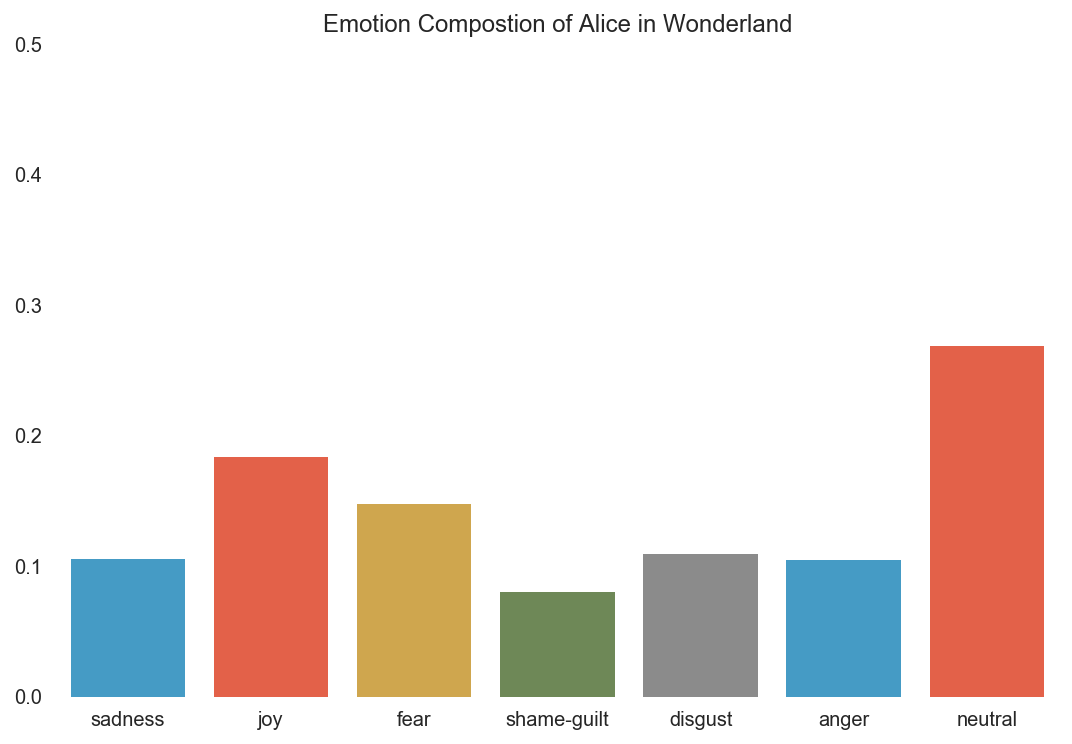

In [161]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
rs = np.random.RandomState(7)
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()

plt.title('Emotion Compostion of Alice in Wonderland')
plt.ylim((0,0.5))
plt.box(on=None)
g = sns.barplot(x = ['sadness','joy','fear','shame-guilt','disgust','anger','neutral'], 
                y = [sadness_mean,joy_mean,fear_mean,shame_mean,disgust_mean,anger_mean,neutral_mean],
                palette=sns.color_palette())

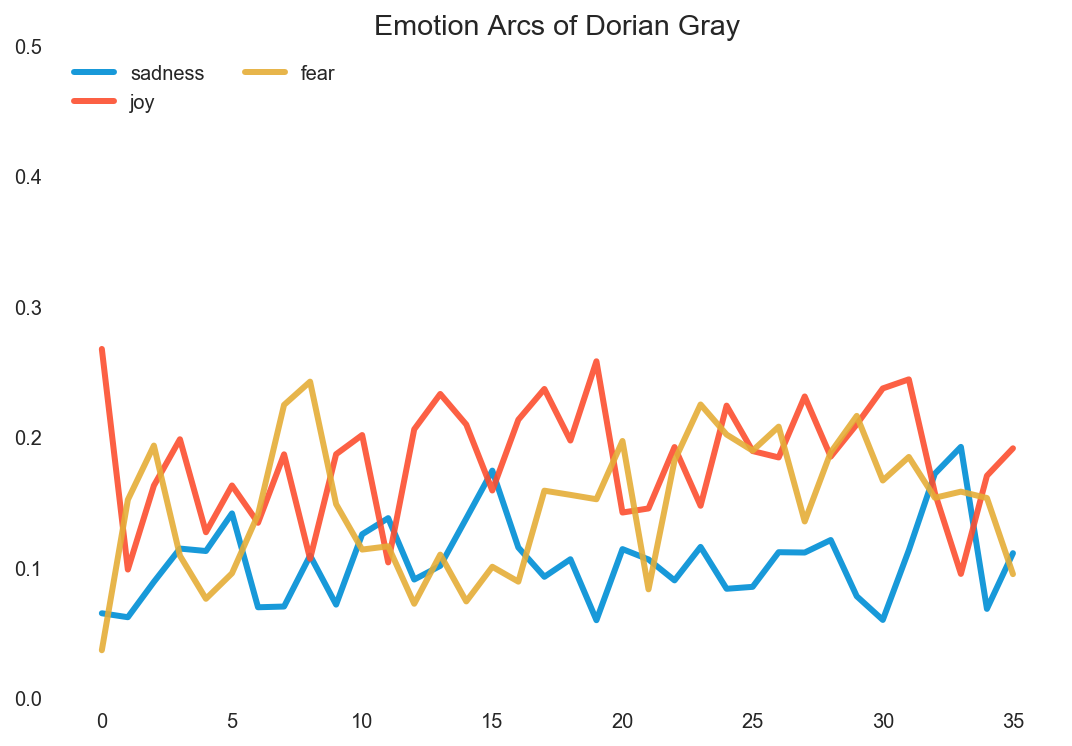

In [128]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
sns.set_style('white')
%matplotlib inline

fig = plt.figure(figsize=(8,6))

# multiple line plot
from matplotlib import lines
lines_array = list(lines.lineStyles.keys())

num=0
for column in gray_arc.drop(['x','shame-guilt','disgust','anger','neutral'], axis=1):
    num+=1
    plt.plot(gray_arc['x'], gray_arc[column], marker='', linewidth=3, alpha=0.9, 
             label=column)

plt.title('Emotion Arcs of Dorian Gray')
plt.ylim(0,0.5)
plt.box(on=None)
plt.legend(loc=2, ncol=2)

In [129]:
indep = pd.read_csv('Declaration of Independence.txt',sep ='\t',names = ['line'],quoting=csv.QUOTE_NONE, encoding='utf-8')

In [131]:
len(indep)

1374

In [133]:
clean_df(indep,'line')
indep.head()

,line
0,course human events becomes necessary
1,one people dissolve political bands connected
2,another assume among powers earth
3,separate equal station laws nature
4,natures god entitle decent respect opinions


In [167]:
indep['shame-guilt'] = indep['line'].apply(lambda x:emo_arc(x,0))
indep['sadness'] = indep['line'].apply(lambda x:emo_arc(x,1))
indep['joy'] = indep['line'].apply(lambda x:emo_arc(x,2))
indep['fear'] = indep['line'].apply(lambda x:emo_arc(x,3))
indep['disgust'] = indep['line'].apply(lambda x:emo_arc(x,4))
indep['anger'] = indep['line'].apply(lambda x:emo_arc(x,5))
indep['neutral'] = indep['line'].apply(lambda x:emo_arc(x,6))

In [163]:
f = lambda x,y: [ x[i:i+y] for i in range(0,len(x),y)]
l = f(range(0, 896), 25)
len(l)

36

In [169]:
shame = []
for j in l:
    shame.append(indep['shame-guilt'].iloc[j[0]:j[-1]+1].mean())
sadness = []
for j in l:
    sadness.append(indep['sadness'].iloc[j[0]:j[-1]+1].mean())
joy = []
for j in l:
    joy.append(indep['joy'].iloc[j[0]:j[-1]+1].mean())
fear = []
for j in l:
    fear.append(indep['fear'].iloc[j[0]:j[-1]+1].mean())
disgust = []
for j in l:
    disgust.append(indep['disgust'].iloc[j[0]:j[-1]+1].mean())
anger = []
for j in l:
    anger.append(indep['anger'].iloc[j[0]:j[-1]+1].mean())
neutral = []
for j in l:
    neutral.append(indep['neutral'].iloc[j[0]:j[-1]+1].mean())
    
x = []
for i in range(0,37):
    x.append(i)
    
indep_arc = pd.DataFrame(list(zip(x,shame,disgust,anger,neutral,sadness,joy,fear,)),
              columns=['x','shame-guilt','disgust','anger','neutral','sadness','joy','fear'])

In [170]:
shame_mean =indep_arc['shame-guilt'].mean()
sadness_mean = indep_arc['sadness'].mean()
joy_mean = indep_arc['joy'].mean()
fear_mean = indep_arc['fear'].mean()
disgust_mean = indep_arc['disgust'].mean()
anger_mean = indep_arc['anger'].mean()
neutral_mean = indep_arc['neutral'].mean()

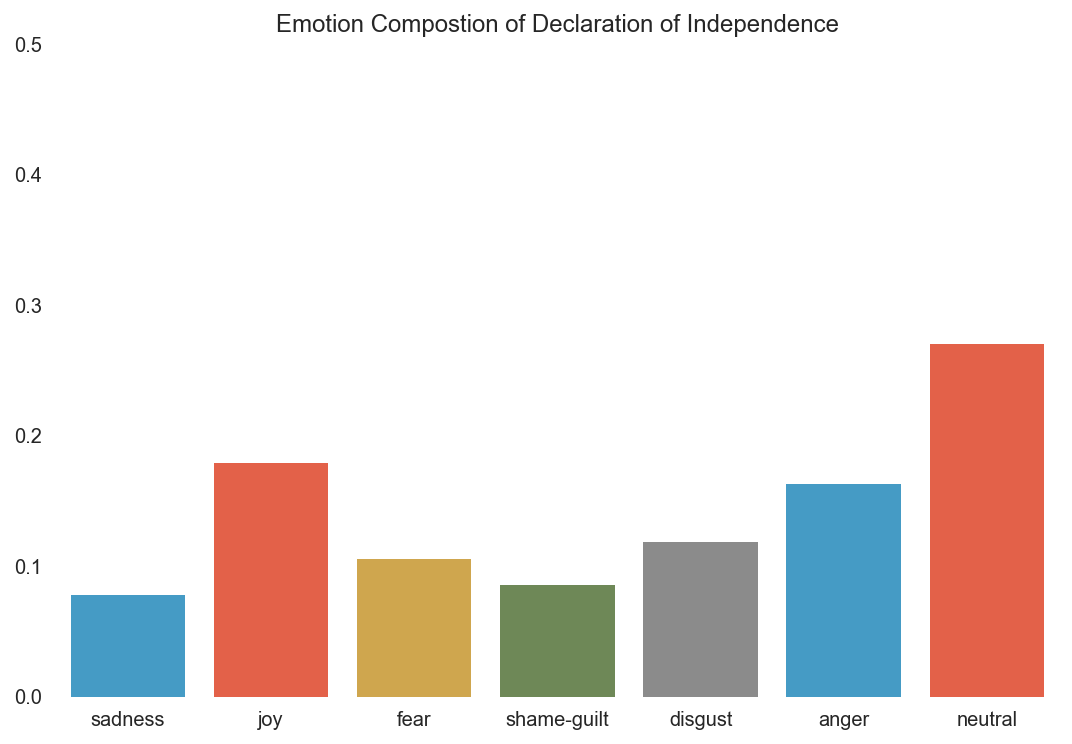

In [171]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
rs = np.random.RandomState(7)
five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]
sns.set_palette(five_thirty_eight)

fig = plt.figure(figsize=(8,6))
ax = fig.gca()

plt.title('Emotion Compostion of Declaration of Independence')
plt.ylim((0,0.5))
plt.box(on=None)
g = sns.barplot(x = ['sadness','joy','fear','shame-guilt','disgust','anger','neutral'], 
                y = [sadness_mean,joy_mean,fear_mean,shame_mean,disgust_mean,anger_mean,neutral_mean],
                palette=sns.color_palette())

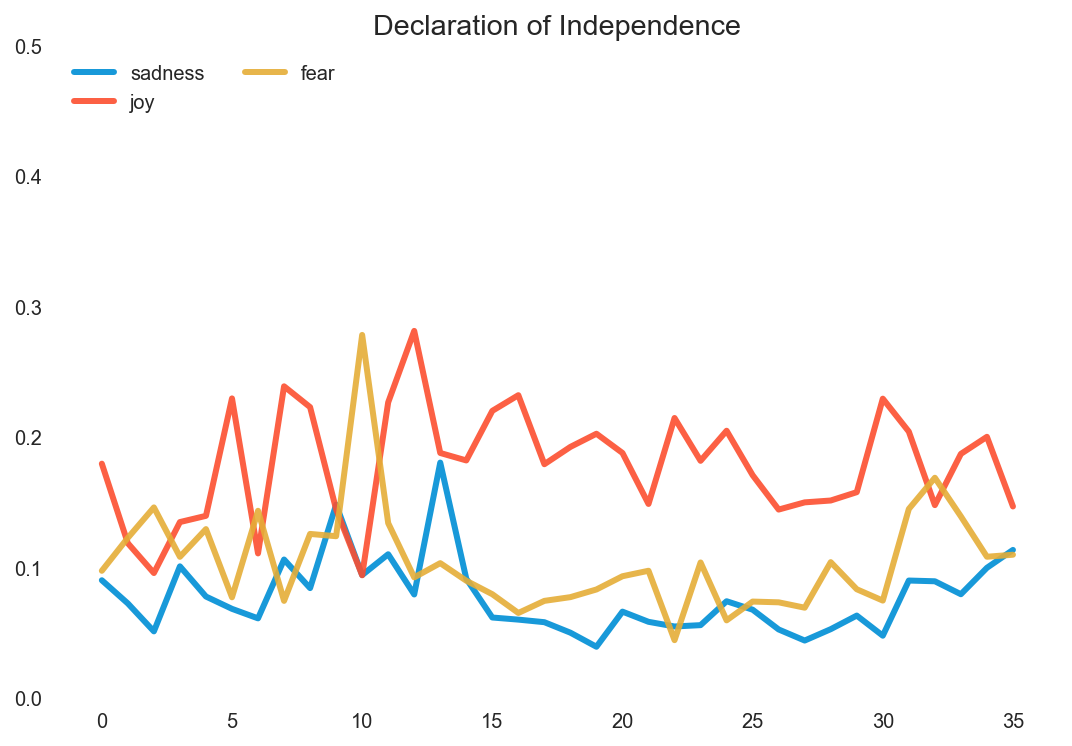

In [139]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
sns.set_style('white')
%matplotlib inline

fig = plt.figure(figsize=(8,6))

# multiple line plot
from matplotlib import lines
lines_array = list(lines.lineStyles.keys())

num=0
for column in indep_arc.drop(['x','shame-guilt','disgust','anger','neutral'], axis=1):
    num+=1
    plt.plot(indep_arc['x'], indep_arc[column], marker='', linewidth=3, alpha=0.9, 
             label=column)

plt.title('Declaration of Independence')
plt.ylim(0,0.5)
plt.box(on=None)
plt.legend(loc=2, ncol=2)